In [1]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/',)
    %cd /content/drive/MyDrive/Thesis/

In [1]:
import real_stuff.evaluating as evaluating
import real_stuff.simulating as simulating
import real_stuff.training as training
from real_stuff.basic_imports import *

import importlib  # doesn't do too much in Colab

Situation 10: sampling 5000 X_i ~ 1D uniform. f1(X) = x^5 up to 0.1. K = 2.
X:
 [0.375 0.951 0.732 ... 0.328 0.816 0.597]
Normalized funcs(X) = Y probabilities:
[[0.305 0.695]
 [0.945 0.055]
 [0.702 0.298]
 ...
 [0.253 0.747]
 [0.795 0.205]
 [0.553 0.447]]
Unnormalized funcs(X):
[[0.275 0.625]
 [0.851 0.049]
 [0.632 0.268]
 ...
 [0.228 0.672]
 [0.716 0.184]
 [0.497 0.403]]
Euclidean distance between those: 5.922487425946332


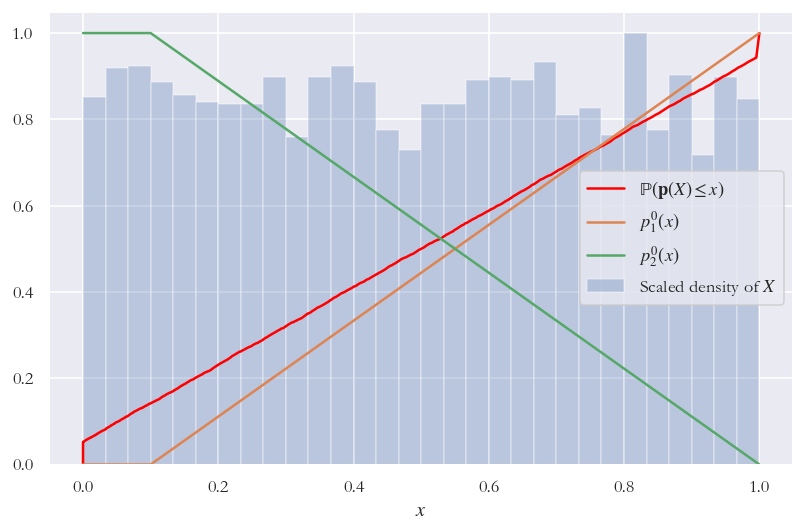

In [5]:
importlib.reload(simulating)
situation = 10

X, funcs, Y_prob, extras = simulating.create_dataset(str(situation), n=5000, viz=True)

In [30]:
importlib.reload(training)
from hyperopt import fmin, tpe, hp, Trials, rand
from tensorflow.keras import optimizers
from tensorflow.keras import losses


def opt_network(situation, n):
    # Parameters we definitely want: widths, Adam settings
    # Probably: L1 penalty, dropout rate, number of layers
    
    def obj(params):
        hw = [16 for _ in range(params['L'])]
        opt = optimizers.Adam(params['lr'])
        X, _, Y_prob, _ = simulating.create_dataset(situation, n, seed=np.random.randint(1000))
        model, *test_sets = training.train_network(X, Y_prob, hidden_widths=hw, val_s=0,
                                                  optimizer=opt, stop=.001)
        Y_test_pred = model.predict(test_sets[0])
        l = losses.categorical_crossentropy(test_sets[2], Y_test_pred).numpy().mean()
        print(l, params)
        return l
    
    
    param_space = {}
    param_space['L'] = hp.randint('Number of layers', 2, 6)
    param_space['lr'] = hp.uniform('Adam learning rate', 0.0005, 0.01)
    tpe_best = fmin(fn=obj, space=param_space, algo=tpe.suggest, max_evals=20)
    return tpe_best

opt_network("5", 512)

  0%|                                                                                  | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:8 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001E5B9386AF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
0.2322069                                                                                                       

{'Adam learning rate': 0.0077114057806420225, 'Number of layers': 2}

In [23]:
best_params

{'Adam learning rate': 0.002046495411712679, 'Number of layers': 3}

Max 0/1-accuracy during training: 0.7426
Epoch 1/420
267/267 [==============================] - 1s 2ms/step - loss: 1.5849 - accuracy: 0.3122 - val_loss: 1.3439 - val_accuracy: 0.4437
Epoch 2/420
267/267 [==============================] - 0s 1ms/step - loss: 1.2794 - accuracy: 0.5234 - val_loss: 1.1842 - val_accuracy: 0.5550
Epoch 3/420
267/267 [==============================] - 0s 1ms/step - loss: 1.1553 - accuracy: 0.5744 - val_loss: 1.0102 - val_accuracy: 0.6413
Epoch 4/420
267/267 [==============================] - 0s 1ms/step - loss: 1.0172 - accuracy: 0.6041 - val_loss: 0.9030 - val_accuracy: 0.6488
Epoch 5/420
267/267 [==============================] - ETA: 0s - loss: 0.9722 - accuracy: 0.60 - 0s 1ms/step - loss: 0.9704 - accuracy: 0.6125 - val_loss: 0.8767 - val_accuracy: 0.6450
Epoch 6/420
267/267 [==============================] - 0s 1ms/step - loss: 0.9496 - accuracy: 0.6225 - val_loss: 0.8316 - val_accuracy: 0.6712
Epoch 7/420
267/267 [==============================] - 0s 1

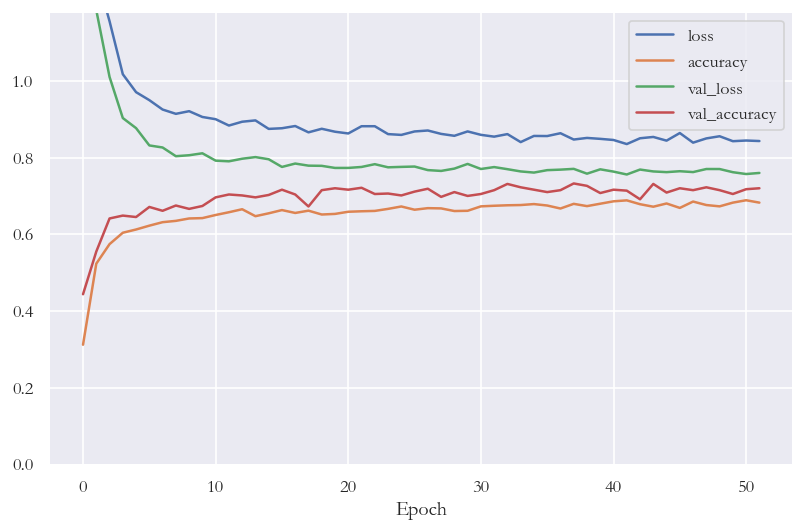

In [4]:
importlib.reload(training)
model, X_test, Y_test, Y_prob_test = training.train_network(X, Y_prob, viz=1)

In [29]:
importlib.reload(evaluating)
evaluating.get_all_quantities_of_interest(model, X_test, Y_test, Y_prob_test)

{'One-hot LL  ': 0.62763745,
 'One-hot KL  ': 0.6276338,
 'One-hot MSE ': 0.07464902,
 'Probab. LL  ': 0.6291616,
 'Probab. KL  ': 0.050583307,
 'Pr. KL_B=1.5': 0.05057554487200829,
 'Probab. MSE ': 0.005879252,
 'Pr. max. di.': 0.3020518061717131,
 'Biases > e. ': 27,
 'Total biases': 69,
 'Weights > e.': 330,
 'Tot. weights': 864,
 'Epsilon     ': 0.001,
 's           ': 357}

Some examples from test set:
X:
[[0.572]
 [0.805]
 [0.76 ]
 ...
 [0.328]
 [0.816]
 [0.597]]
True:
[[0.    0.001 0.18  0.76  0.059]
 [0.    0.    0.    0.108 0.892]
 [0.    0.    0.001 0.231 0.768]
 ...
 [0.004 0.356 0.621 0.02  0.   ]
 [0.    0.    0.    0.09  0.91 ]
 [0.    0.    0.112 0.787 0.101]]
Predict:
[[0.    0.001 0.264 0.67  0.065]
 [0.    0.    0.    0.182 0.817]
 [0.    0.    0.001 0.247 0.751]
 ...
 [0.005 0.495 0.438 0.062 0.001]
 [0.    0.    0.    0.17  0.83 ]
 [0.    0.    0.179 0.719 0.102]]


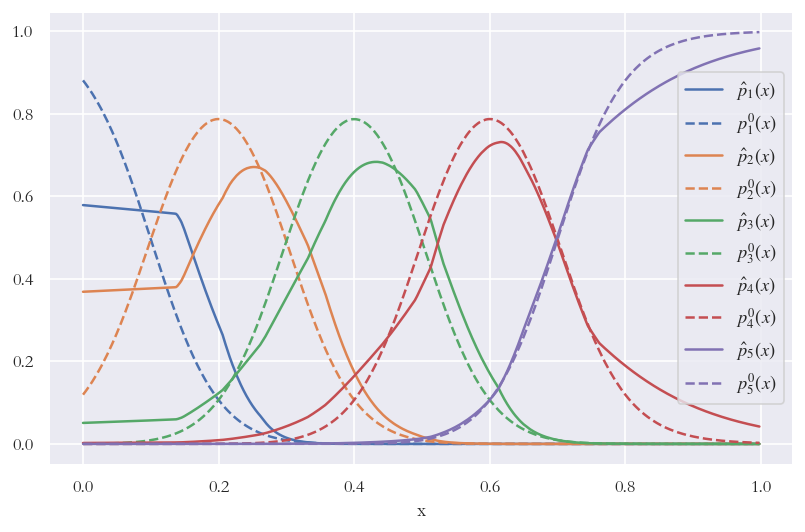

In [7]:
importlib.reload(evaluating)
evaluating.visualize(model, X_test, Y_test, Y_prob_test)

## Temp

In [ ]:
!python test.py 6.2

2.0
{'t^0.2': array([0.1       , 0.10001924, 0.10003847, ..., 0.68399227, 0.68412384,
       0.68425543])}


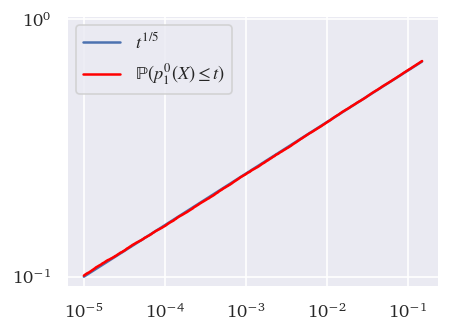

In [ ]:
# NOTE: I've destroyed this thing but it's useless anyway

def alpha_C_finder(t_space, p_X_small, alphas):
    # TODO!!
    result = {}
    for alpha in alphas:
        t_alpha = np.power(t_space, alpha)
        C = np.ceil(np.max(p_X_small / t_alpha))
        print(C)
        result[f't^{alpha}'] = t_alpha
    return result


t_space = np.geomspace(1e-5, 0.15, 10_000)
p_X_small = np.array([np.mean(Y_prob[:, 0] <= t) for t in t_space])
alphas = [1 / 5]
results = alpha_C_finder(t_space, p_X_small, alphas)
print(results)

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "figure.dpi": 120,
      "figure.figsize": [4, 3]
     }
plt.rcParams.update(rc)

for alpha in alphas:
    C_t_alpha = results[f't^{alpha}']

    plt.plot(t_space, C_t_alpha, label="$t^{1/5}$")
    plt.plot(t_space, p_X_small, label="$\mathrm{\mathbb{P}}(p^0_1(X) \leq t)$",
             color="red")
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(top=max(p_X_small) * 1.5)
    plt.savefig("empi.pdf")
    plt.show()

In [ ]:
!python test.py 5

Starting 10 runs of situation 5 with network [16, 16, 16, 16, 16].
Traceback (most recent call last):
  File "test.py", line 43, in <module>
    multiple_runs(situation, N, hw)
  File "test.py", line 15, in multiple_runs
    model, *test_sets = training.train_network(X, Y_prob, hidden_widths=hw)
  File "/content/drive/My Drive/Thesis/real_stuff/training.py", line 66, in train_network
    batch_size=12, use_multiprocessing=True, verbose=viz)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/

In [ ]:
def f1(X, m=30):
#     y = 0
#     for k in range(0, m, 1):
#         y += ((-1)**k)*(X**(1+2*k))/np.math.factorial(1+2*k)
#     return y
    return sum(
        [(-1) ** (i+1) * X ** (2*i-1) / np.math.factorial(2*i-1) for i in range(1, m, 1)]) + .00001


X = np.random.uniform(size=1000)
order = np.argsort(X)
plt.plot(X[order], f1(X[order], 50), color='red')
plt.plot(X[order], np.sin(X[order]), color='blue')
f1(1), np.sin(1)